In [12]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

2025-07-26 15:41:37.093702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-26 15:41:42.545158: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-26 15:41:42.545975: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-26 15:41:49.376269: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-26 15:41:58.691852: W tensorflow/com

## Coleta e Tratamento dos Dados

In [6]:
# Escolhendo ação e periodo dos dados

ACAO = 'ITUB'            # Símbolo da empresa (ex: 'DIS' para Disney)
START_DATE = '2021-01-01'  # Data de início da coleta de dados
END_DATE = '2025-07-01'    # Data de fim da coleta de dados
SEQUENCE = 60       # Número de dias passados para prever o próximo dia (timestep do LSTM)

df = yf.download(ACAO, start=START_DATE, end=END_DATE)


/tmp/ipykernel_7697/4059216447.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ACAO, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed


In [7]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,ITUB,ITUB,ITUB,ITUB,ITUB
Date,,,,,
2021-01-04,3.470927,3.612356,3.453248,3.600570,43224515
2021-01-05,3.447355,3.476820,3.358962,3.376641,48983354
2021-01-06,3.535749,3.594678,3.453248,3.470927,61586084
2021-01-07,3.600570,3.618249,3.529855,3.600570,50293636
2021-01-08,3.576998,3.641820,3.547534,3.624141,58275953


In [8]:
# Tratamento dos dados

data = df['Close'].values.reshape(-1, 1) # selecionando apenas coluna Cloe

# Normalizar os dados (escalar para o intervalo de 0 a 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

## Criação das sequências 

In [10]:
def create_sequences(dataset, seq_len):
    X, y = [], []
    for i in range(len(dataset) - seq_len):
        X.append(dataset[i:(i + seq_len), 0])
        y.append(dataset[i + seq_len, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, SEQUENCE)

train_size = int(len(X) * 0.8) # 80/20
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape dos dados para o formato esperado pelo LSTM: [samples, timesteps, features]
# Onde features é 1 porque estamos usando apenas a coluna 'Close'
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [11]:
print(f"\nPré-processamento e divisão dos dados concluídos.")
print(f"  Shape de X_train: {X_train.shape}")
print(f"  Shape de y_train: {y_train.shape}")
print(f"  Shape de X_test: {X_test.shape}")
print(f"  Shape de y_test: {y_test.shape}")


Pré-processamento e divisão dos dados concluídos.
  Shape de X_train: (853, 60, 1)
  Shape de y_train: (853,)
  Shape de X_test: (214, 60, 1)
  Shape de y_test: (214,)


## Desenvolvimento do Modelo LSTM

In [13]:
model = Sequential()
# Primeira camada LSTM: retorna sequências para a próxima camada LSTM
model.add(LSTM(units=50, return_sequences=True, input_shape=(SEQUENCE, 1)))
model.add(Dropout(0.2)) # 20% dos neurônios são desativados aleatoriamente para regularização

# Segunda camada LSTM: não retorna sequências, pois é a última camada LSTM antes da camada de saída
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2)) # Mais dropout para regularização

# Camada de saída densa: um único neurônio para prever o preço de fechamento
model.add(Dense(units=1))

# Compilar o modelo:
# - Otimizador 'adam' é uma escolha popular e eficaz.
# - 'mean_squared_error' (MSE) é uma função de perda comum para problemas de regressão.
model.compile(optimizer='adam', loss='mean_squared_error')

# Exibir um resumo da arquitetura do modelo
model.summary()

2025-07-26 15:45:54.643341: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Treinamento do Modelo

In [14]:
history = model.fit(
    X_train, y_train,
    epochs=50,           # Número de épocas (ajuste conforme necessário)
    batch_size=32,       # Tamanho do lote (ajuste conforme necessário)
    validation_split=0.1, # 10% dos dados de treino serão usados para validação durante o treinamento
    verbose=1            # Exibir progresso do treinamento
)

Epoch 1/50
24/24 [==============================] - 22s 92ms/step - loss: 0.0273 - val_loss: 0.0181
Epoch 2/50
24/24 [==============================] - 1s 49ms/step - loss: 0.0046 - val_loss: 0.0055
Epoch 3/50
24/24 [==============================] - 1s 48ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 4/50
24/24 [==============================] - 1s 48ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 5/50
24/24 [==============================] - 1s 49ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 6/50
24/24 [==============================] - 1s 48ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 7/50
24/24 [==============================] - 1s 48ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 8/50
24/24 [==============================] - 1s 49ms/step - loss: 0.0030 - val_loss: 0.0035
Epoch 9/50
24/24 [==============================] - 1s 49ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 10/50
24/24 [==============================] - 1s 49ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 11

In [15]:
predictions_scaled = model.predict(X_test)

7/7 [==============================] - 1s 14ms/step


## Avaliação do Modelo

Métricas de Avaliação no Conjunto de Teste:
  MAE (Mean Absolute Error): 0.10
  RMSE (Root Mean Square Error): 0.14
  MAPE (Mean Absolute Percentage Error): 1.9188377719189564%


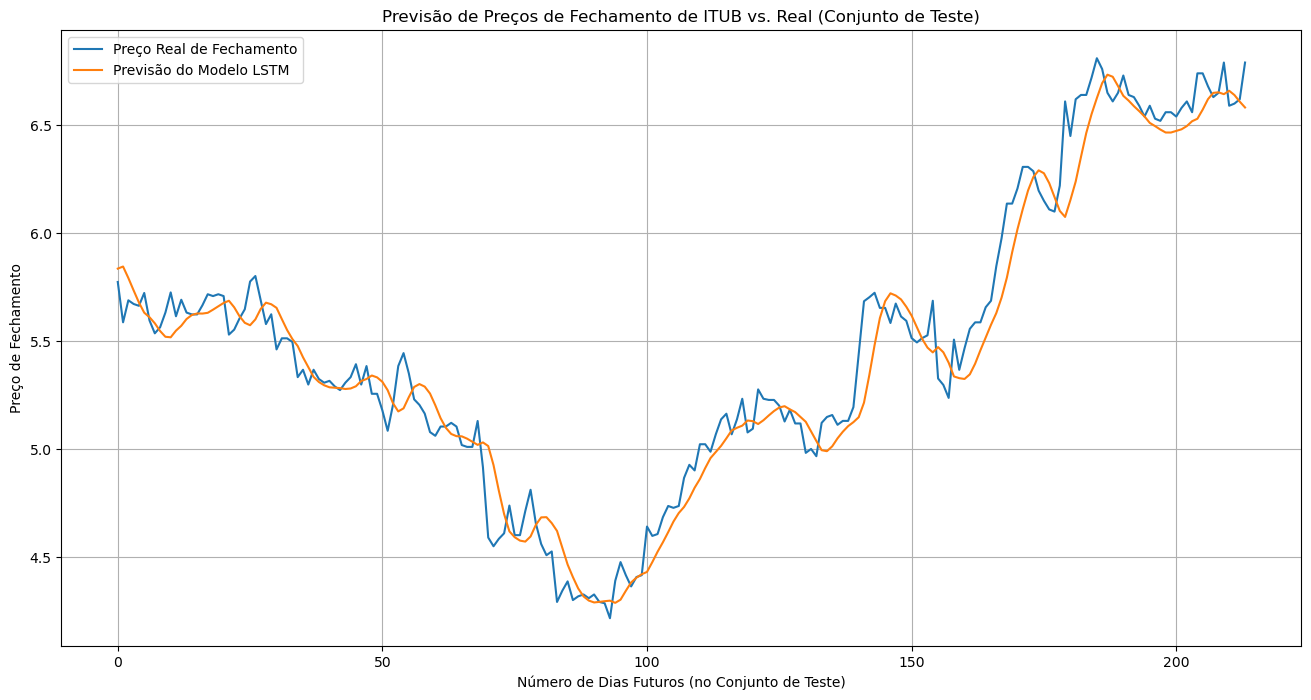

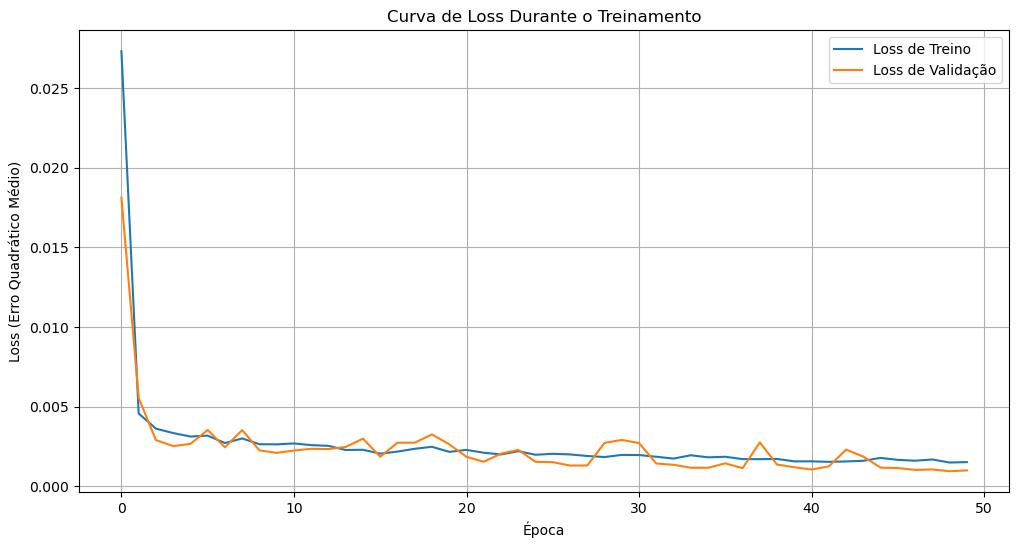

In [18]:
# Inverter a normalização para obter os valores reais dos preços
# Lembre-se que o scaler foi treinado com os dados originais.
predictions = scaler.inverse_transform(predictions_scaled)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calcular métricas de avaliação
mae = mean_absolute_error(y_test_unscaled, predictions)
rmse = math.sqrt(mean_squared_error(y_test_unscaled, predictions))

# Calcular MAPE (Mean Absolute Percentage Error)
# Cuidado com divisões por zero se houver valores reais muito próximos de zero
mape = np.mean(np.abs((y_test_unscaled - predictions) / y_test_unscaled)) * 100
# Se o MAPE resultar em NaN devido a valores zero no denominador, trate-o
if np.isnan(mape) or np.isinf(mape):
    print("Atenção: MAPE resultou em NaN/Infinito, pode haver zeros nos valores reais de teste.")
    mape = "Não Calculável" # Ou outro indicador apropriado

print(f"Métricas de Avaliação no Conjunto de Teste:")
print(f"  MAE (Mean Absolute Error): {mae:.2f}")
print(f"  RMSE (Root Mean Square Error): {rmse:.2f}")
print(f"  MAPE (Mean Absolute Percentage Error): {mape}%")

# --- Visualização das Previsões vs. Valores Reais ---
plt.figure(figsize=(16, 8))
plt.plot(y_test_unscaled, label='Preço Real de Fechamento')
plt.plot(predictions, label='Previsão do Modelo LSTM')
plt.title(f'Previsão de Preços de Fechamento de {ACAO} vs. Real (Conjunto de Teste)')
plt.xlabel('Número de Dias Futuros (no Conjunto de Teste)')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()

# --- Visualização da Curva de Perda Durante o Treinamento ---
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Loss de Treino')
plt.plot(history.history['val_loss'], label='Loss de Validação')
plt.title('Curva de Loss Durante o Treinamento')
plt.xlabel('Época')
plt.ylabel('Loss (Erro Quadrático Médio)')
plt.legend()
plt.grid(True)
plt.show()

## Salvando o Modelo

In [21]:
import joblib
import os
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = 'sagemaker-us-east-2-982534382598'

s3_model_prefix = 'lstm-stock-prediction-artifacts'

local_model_dir = 'temp_model_artifacts'
os.makedirs(local_model_dir, exist_ok=True)

local_model_path = os.path.join(local_model_dir, 'lstm_stock_prediction_model.h5')
local_scaler_path = os.path.join(local_model_dir, 'scaler.joblib')

model.save(local_model_path)
print(f"Modelo salvo localmente em: {local_model_path}")

joblib.dump(scaler, local_scaler_path)
print(f"Scaler salvo localmente em: {local_scaler_path}")

s3_model_uri = sagemaker_session.upload_data(
    path=local_model_path,
    bucket=bucket,
    key_prefix=s3_model_prefix
)
print(f"Modelo enviado para S3: {s3_model_uri}")

s3_scaler_uri = sagemaker_session.upload_data(
    path=local_scaler_path,
    bucket=bucket,
    key_prefix=s3_model_prefix
)
print(f"Scaler enviado para S3: {s3_scaler_uri}")

print("\nModelo e Scaler salvos no S3 e prontos para uso na API!")

Modelo salvo localmente em: temp_model_artifacts/lstm_stock_prediction_model.h5
Scaler salvo localmente em: temp_model_artifacts/scaler.joblib
Modelo enviado para S3: s3://sagemaker-us-east-2-982534382598/lstm-stock-prediction-artifacts/lstm_stock_prediction_model.h5
Scaler enviado para S3: s3://sagemaker-us-east-2-982534382598/lstm-stock-prediction-artifacts/scaler.joblib

Modelo e Scaler salvos no S3 e prontos para uso na API!
